# Lecture 19: Unsupervised learning

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1N2lOE8YOXNuekxMtflQCB3eM3I6Bx7-w)

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2025-03-07 05:32:18


## Unsupervised learning overview

### Labelled data is scarce

The majority of data is unlabeled: we have input features $\mathbf{X}$, but no labels $\mathbf{y}$.

Imagine that you want to detect defective items on a manufacturing line. You can collect images of the  items on the  manufacturing line easily and automatically, but if you want to train a classifier to predict whether an item is defective or not, you will need to label every image.

This labelling generally requires human experts to sit down and go through the images by hand, which is time consuming, tedious, and prone to errors. As a result, labelling is often only done on a small subset of the available images.

With unsupervised learning, you do not need labelled data!

### Types of unsupervised learning

We will cover three types of unsupervised learning.

1. *Clustering*: Group similar data instances into clusters.
2. *Density estimation*: Estimate the probability distribution of data (for use as a generative model to generate new data instances or to estimate probability densities).
3. *Anomaly detection*: Detect anomalous data.

## Clustering with K-means

### Clustering overview

*Clustering* is the task of identifying similar instances and assigning them to *clusters*, or groups of similar instances.

Consider the Iris dataset, which classifies each instance into one of three classes:

In [2]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Let's plot the petal width against the petal length, both with and without different markers for the classes:

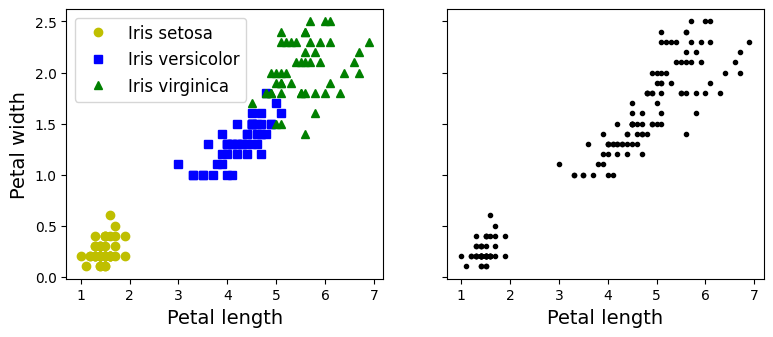

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

When the instances are plotted without different markers to differentiate the classes, as in the figure on the right, it is not obvious that the upper-right cluster is composed of two distinct sub-clusters.

There is no universal definition of what a cluster is. It depends on the context: different algorithms will capture different kinds of clusters.

Some algorithms look for instances centered around a particular point, called a *centroid*. Others look for continuous regions of densely packed instances.

### K-means clustering overview

Cluster data into different subsets.  

First, let's consider how K-means represents clusters, then we'll consider the algorithm to find clusters.

- Each cluster is defined by a centroid.
- Each data instance is allocated a cluster (equivalently, associated with a centroid).

Let's generate some blobs to use as a dataset, and run the K-Means algorithm for 1, 2, and 3 iterations to see how the centroids move around:

In [5]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

Now let's plot them:

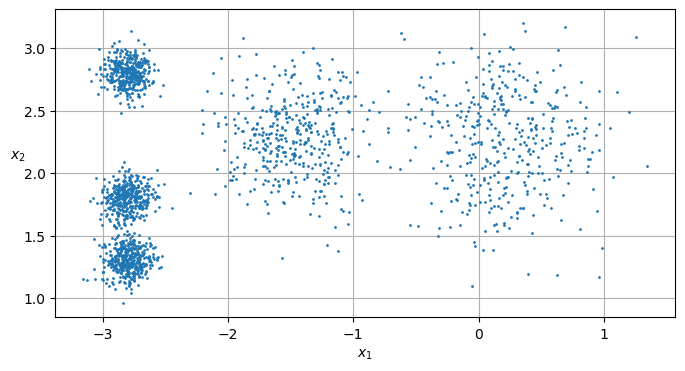

In [6]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()

#### Cluster with Scikit-Learn K-means

Must set number of clusters to consider.

In [7]:
k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance assigned to one of the five clusters:

In [8]:
y_pred

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

A *centroid* is estimated for each cluster (i.e., cluster centers).  

In [9]:
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

In [10]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

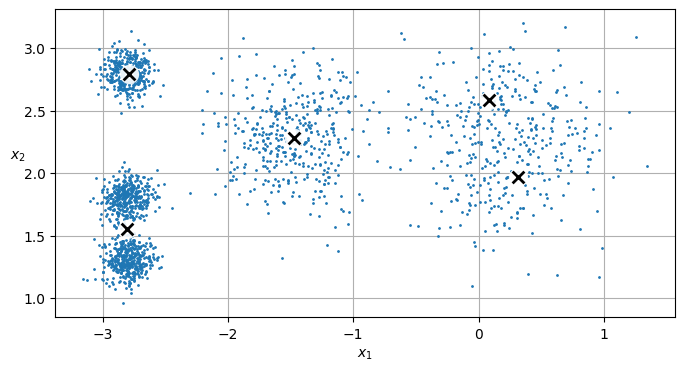

In [11]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plot_centroids(kmeans.cluster_centers_)
plt.gca().set_axisbelow(True)
plt.grid()

#### Predictions

Can make predictions for new instances:

In [12]:
import numpy as np

In [13]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3], dtype=int32)

#### Decision boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

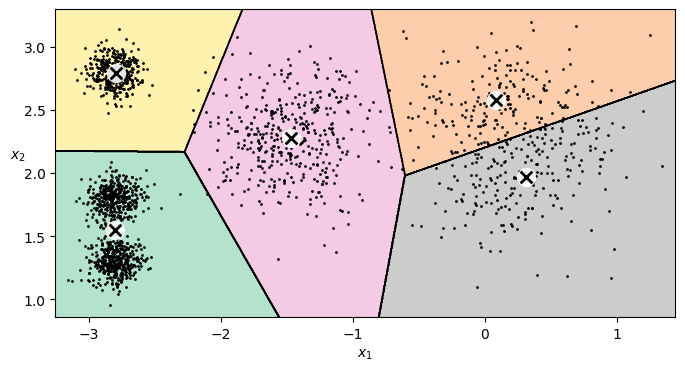

In [14]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Typically, each data instance is asigned to the cluster with the closest centroid (*hard clustering*).

#### Hard versus soft clustering

*Hard clustering* corresponds to selecting the closest cluster for each instance.

Alternatively, with *soft clustering* compute a similarly score based on the confidence of being associated with each cluster.  This is given by the (Euclidean) distance between a data instance and the cluster centroid.

Can be computed by the `transform()` method:

In [15]:
kmeans.transform(X_new).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

Can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [16]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2)
               - kmeans.cluster_centers_, axis=2).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

### K-means algorithm

If know centroids...

can cluster data instances by finding closest centroid.

If know clusters... 

can compute centroid of data instances in cluster.

K-means finds centroids and clusters iteratively following this approach.

#### Algorithm

Must set number of clusters to consider, $k$.

Then run iterative algorithm to continually update estimates of centroids and cluster allocations.

1. Randomly initialise centroids.
2. Label instances by closest centroid.
3. Calculate new centroid of each cluster by taking mean of instances in the cluster.
4. Repeat steps 2 to 3. 

#### Algorithm visually

Let's run K-Mean algorithm for 1, 2 and 3 iterations, to see how the centroids move.

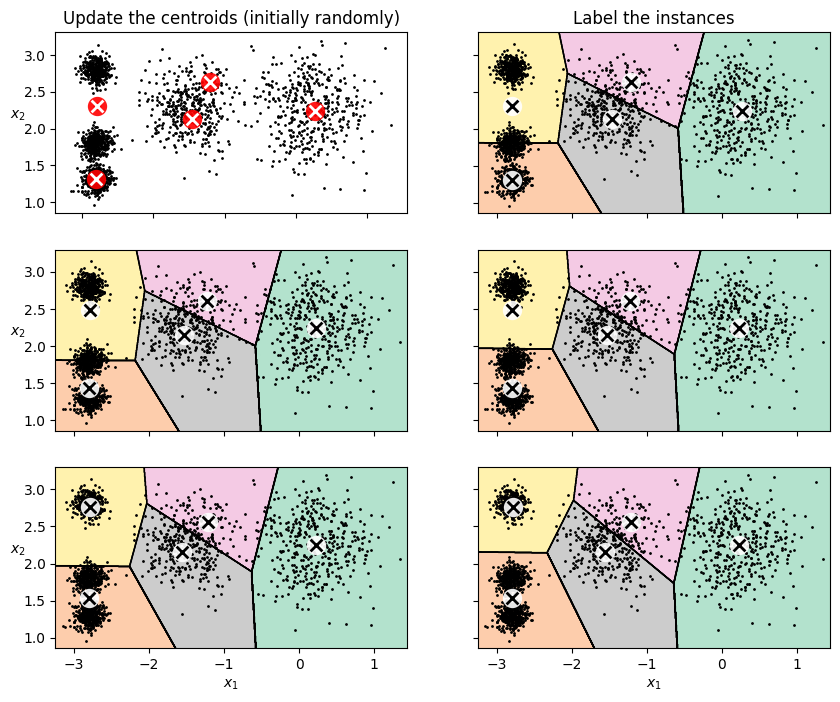

In [17]:
starting_random_state = 6
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=starting_random_state)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=starting_random_state)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=starting_random_state)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

#### Convergence

Convergence is guaranteed since mean squared distance between instances and their closest centroid can only go down at each step.

Usually only a relatively small number of iterations are required.

#### Variability

While the algorithm is guaranteed to converge, it might not converge to the desired solution.

Final clusters are highly dependent on initial random centroid selection.

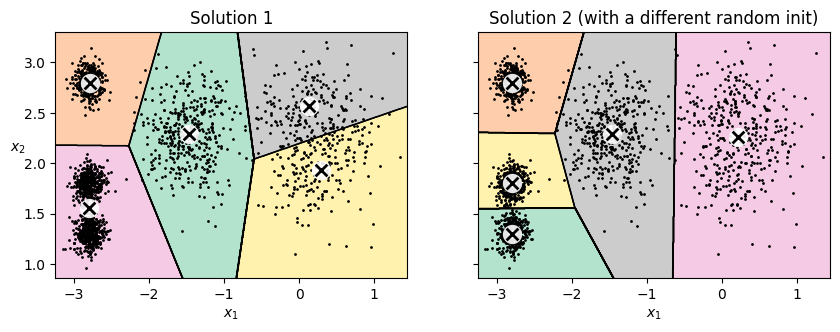

In [18]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=9)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1",
                          "Solution 2 (with a different random init)")

#### Manual initialisation

If have a rough idea of good clustering, can set manual initialisation.

In [19]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

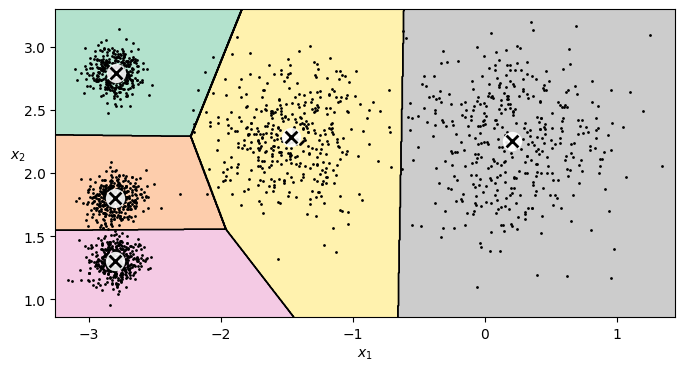

In [20]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

#### Performance measure

In order to assess whether a set of clusters is good, need to have some measure of performance.

Goodness can be estimated by *sum of squared distances between instances and their clustered centroid* (low good).

Score given by negative of this qualtity (so high good).

In [21]:
kmeans.score(X)

-211.59853725816828

#### Multiple initialisations

Now have measure of performance, can run multiple times with different centroid initialisations and then select clustering with highest score.

Controlled by `n_init` variable in Scikit-Learn.

In [22]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=2)

Recover good clusters.

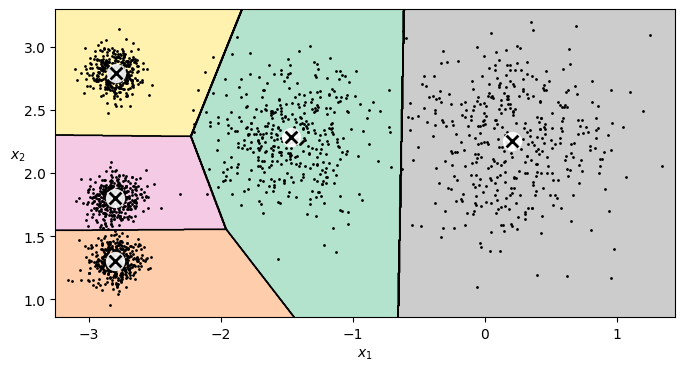

In [23]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)

#### Extensions

- Acceleration
- Mini-batch
- Selecting number of clusters

#### Limitations

- Need to run several times with different initialisations
- Need to specify number of clusters
- Does not behave well when clusters have varying sizes, different densities, or non-spherical shapes.

## Density estimation with Gaussian mixture models

Aim of density estimation is to estimate a *probability distribution* from which data were drawn.  

Can then generate new data instances (generative AI) and also perform probability density estimation.

A *Gaussian mixture model* (GMM) is a probabilistic model that assumes that the instances were generated from a mixture of a number of Gaussian distributions whose parameters are unknown.

### Gaussian mixture model description

Instances generated from a Gaussian distribution form clusters that look like ellipsoids. Each cluster can have a different ellipoidal shape, size, density, and orientation.

Scikit-Learn contains several GMM variants. In the simplist, the `GaussianMixture` class, you must know in advance the number of Gaussian distributions $k$.

The dataset $\mathbf{X}$ is assumed to have been generated through the following probabilistic process:

- For each instance, a cluster is picked randomly from among $k$ clusters. The probability of choosing the $j^{\text{th}}$ cluster is defined by the clusters weight, $\phi^{(j)}$. The index of the cluster chosen for the $i^{\text{th}}$ instance is noted $z^{(i)}$.
- If $z^{(i)}=j$, meaning the $i^{\text{th}}$ instance has been assigned to the $j^{\text{th}}$ cluster, the location $\mathbf{x}^{(i)}$  of this instance is sampled randomly from the Gaussian distribution with mean $\mathbf{\mu}^{(j)}$ and covariance matrix ${\sum}^{(j)}$. This is noted as:

$$\mathbf{x}^{(i)} \sim \mathcal{N} \left( \mathbf{\mu}^{(j)}, {\sum}^{(j)} \right)$$

Let's generate some random blobs to use as a dataset again.

In [24]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

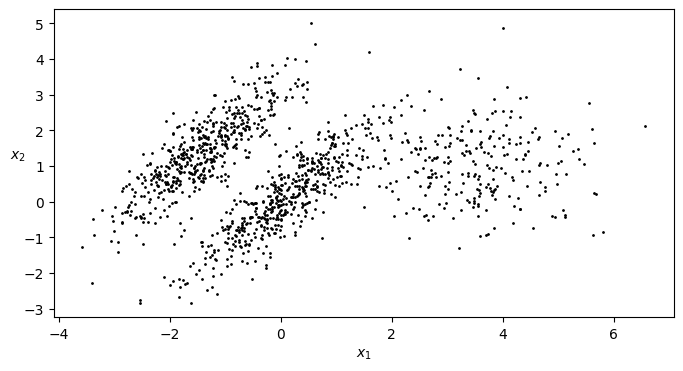

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0);

### Training

Let's train a Gaussian mixture model.  

The model is trainined by the *expectation-maximisation* (EM) algorithm.  We won't go into technical details but has similarites with the K-means algorithm.  It initialises clusters randomly, then repeats an *expectation* step (cf. assign instances to clusters) and a *maximisation* step (cf. updating clusters).

In [26]:
from sklearn.mixture import GaussianMixture

In [27]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters of the GMM estimated:

In [28]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [29]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [30]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

### Predictions

The model can be used to predict which cluster each instance belongs to (hard clustering) or to estimate probabilities that it came from each cluster. 

For this, just use `predict()` method or the `predict_proba()` method:

In [31]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1])

In [32]:
gm.predict_proba(X).round(3)

array([[0.   , 0.023, 0.977],
       [0.001, 0.016, 0.983],
       [1.   , 0.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]])

### Generative model

It is a generative model, so you can sample new instances from it (and get their labels).

In [33]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [34]:
y_new

array([0, 0, 1, 1, 1, 2])

### Probability density estimation

Can estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method:

In [35]:
gm.score_samples(X).round(2)

array([-2.61, -3.57, -3.33, ..., -3.51, -4.4 , -3.81])

A valid probability density must integrate to one over the parameters space.  Let's check!

In [36]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

np.float64(0.9999999999225088)

### Visualise

Let's plot the resulting probability densities and decision boundaries for clustering (dashed lines).

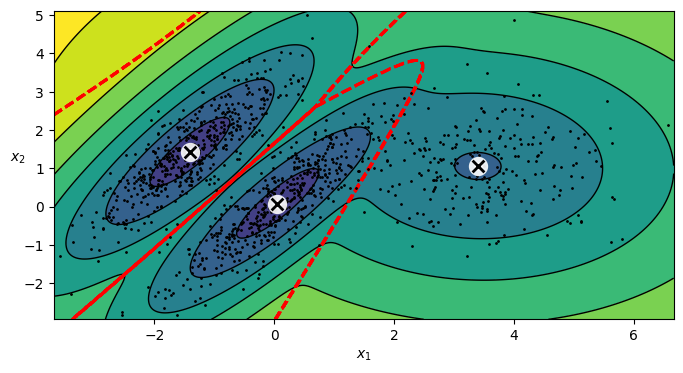

In [37]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)

## Anomaly detection with Gaussian mixture models

GMMs can be used for *anomaly detection*.

Instances located in low density regions can be considered anomalies. 

Must define what density threshold constitutes an anomaly.

In [38]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 1) # Find threshold corresponding to 1% of instances
anomalies = X[densities < density_threshold]

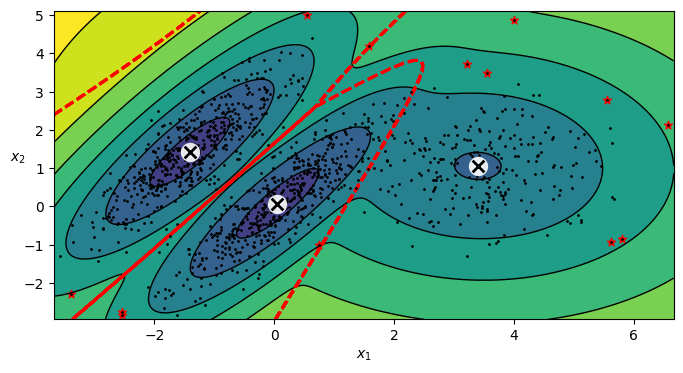

In [39]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1);